# Week 12: Telescope Image Reduction Assignment (25 pts)
We will be reducing images of Neptune with a similar, but slightly different technique to the one we used to reduce Uranus images in class.

For images of Neptune, we use a procedure called *stacking*, where three snapshots of Neptune are taken in different parts of the telescope's field of view, then stacked on top of each other to amplify signal and remove atmospheric and detector artifacts.

In [88]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import RectBivariateSpline
import astroscrappy
import image_registration

# Part 1. Open relevant images and make the sky image (5 pts)

In [89]:
filt_name = 'h'
target_name = 'Neptune'
filepath = './data/'

In [90]:
neptune_1f = filepath + target_name + '_' + filt_name + '_1.fits'
neptune_2f = filepath + target_name + '_' + filt_name + '_2.fits'
neptune_3f = filepath + target_name + '_' + filt_name + '_3.fits'
flatf = filepath + 'flat_master_' + filt_name + '.fits'

In [91]:
neptune_1 = fits.open(neptune_1f,ignore_warnings=True,ignore_missing_end=True)
neptune_1_data = neptune_1[0].data
neptune_2 = fits.open(neptune_2f,ignore_warnings=True,ignore_missing_end=True)
neptune_2_data = neptune_2[0].data
neptune_3 = fits.open(neptune_3f,ignore_warnings=True,ignore_missing_end=True)
neptune_3_data = neptune_3[0].data

Let's plot up the Neptune images to see how they look:

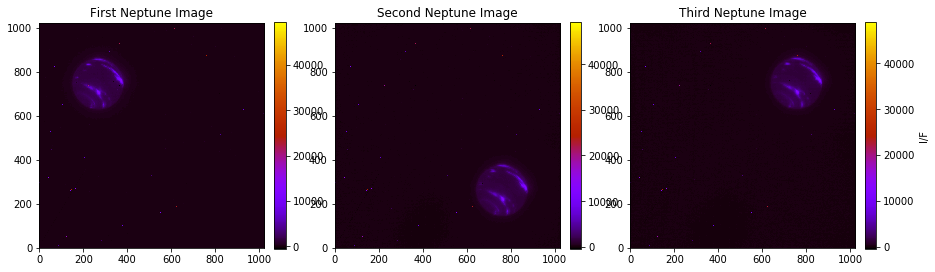

In [92]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(neptune_1_data,origin='lower left',cmap='gnuplot')
plt.title('First Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(neptune_2_data,origin='lower left',cmap='gnuplot')
plt.title('Second Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(neptune_3_data,origin='lower left',cmap='gnuplot')
plt.title('Third Neptune Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

These images are taken in 3 Frame Dither Pattern, where Neptune is placed in 3 different parts of the telescope's field of view in order to correct for detector and atmospheric effects. In this method, the "sky" image is created by finding the median value at each pixel over all three images.

To start we'll make an array called ```frames```, which will store the image data for all three Neptune images.

In [93]:
frames = np.asarray([neptune_1_data,neptune_2_data,neptune_3_data])
frames.shape

(3, 1024, 1024)

<font color=goldenrod>**_Code for you to write_**</font>

Write a function called ```make_sky()``` which takes the ```frames``` array and returns a ```sky``` image. The sky image is an image comprised of the *median* value of each pixel across the three Neptune images. You can use the ```np.median()``` function to do this (make sure to specify ```axis=0``` so that it knows to calculate the median across the 3 images). Use this function to generate an image called ```sky_h```, which we'll use for sky subtraction (2.5 pts):

In [94]:
def make_sky(frames):
    sky = np.median(frames,axis=0)
    return sky

In [95]:
sky_h = make_sky(frames)

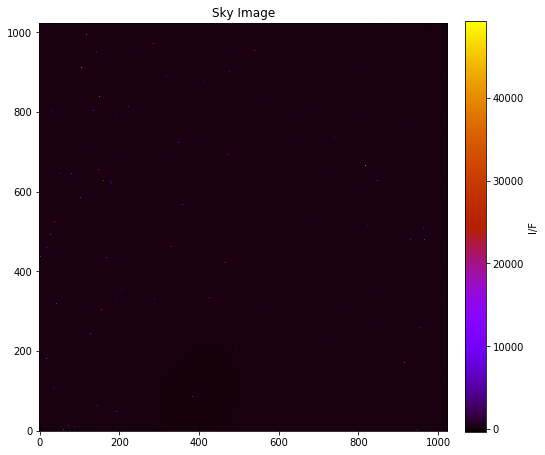

In [96]:
plt.figure(figsize=(8,8))
plt.imshow(sky_h,origin='lower left',cmap='gnuplot')
plt.title('Sky Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Because the sky image is comprised of the median pixel value at each location, bad pixels across all three images will be accounted for, while true signal (such as brightness from Neptune) will not.

<font color=goldenrod>**_Code for you to write_**</font>

Write a function called ```subtract_sky()``` which takes your ```frames``` array and the ```sky``` image and subtracts the sky image from each frame. This function should return an array which is the same shape as your ```frames``` array. This function be similar to the subtract_sky function from the in-class assignment, but you'll need to use a for loop to iterate through all 3 images and subtract the sky from each.

In [97]:
def subtract_sky(frames,sky):
    frames_skysub = np.zeros(shape=frames.shape)
    for i in range(frames_skysub.shape[0]):
        frames_skysub[i] = frames[i] - sky
    return frames_skysub

Use the ```subtract_sky()``` function to subtract the sky from all 3 images. 

In [98]:
frames_skysub = subtract_sky(frames,sky_h)
frames_skysub.shape

(3, 1024, 1024)

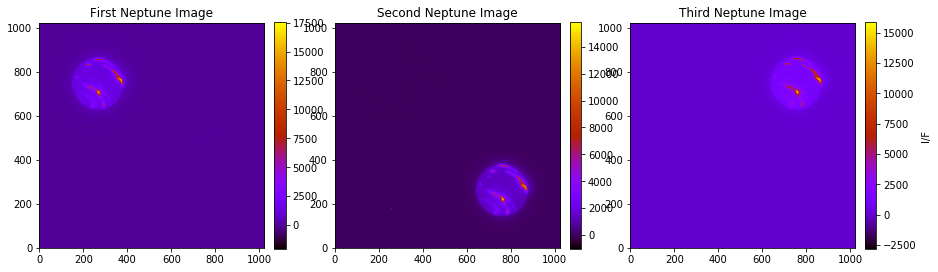

In [99]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(frames_skysub[0],origin='lower left',cmap='gnuplot')
plt.title('First Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(frames_skysub[1],origin='lower left',cmap='gnuplot')
plt.title('Second Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(frames_skysub[2],origin='lower left',cmap='gnuplot')
plt.title('Third Neptune Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

# Part 2. Flat-fielding (2.5 pts)
We will use the same flat-field images we used in class, and use it to scale each frame in our frames_skysub array.

Text(0.5, 1.0, 'Flat-field Image')

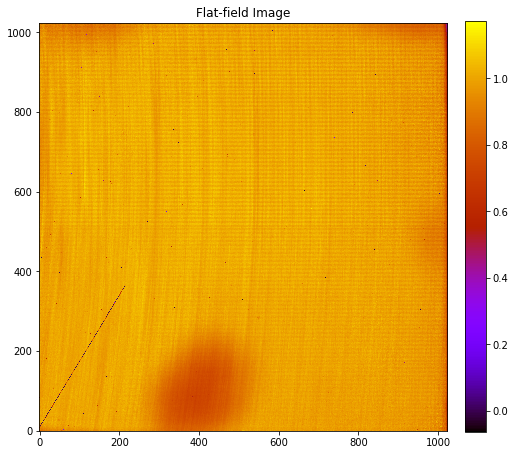

In [100]:
flat_fits = fits.open(flatf,ignore_warnings=True,ignore_missing_end=True)
flat = flat_fits[0].data
plt.figure(figsize=(8,8))
plt.imshow(flat,origin='lower left',cmap='gnuplot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flat-field Image')

<font color=goldenrod>**_Code for you to write_**</font>

Write a function called ```apply_flat``` which scales each frame in the ```frames_skysub``` array by the ```flat``` image and returns an array that is the same shape as the frames_skysub array. Again, this will be similar to the function we wrote in the in-class assignment, but this time you need to divide each frame in the array by the flat image.

In [101]:
def apply_flat(frames,flat):
    frames_flat = np.zeros(shape=frames.shape)
    for i in range(frames_flat.shape[0]):
        with np.errstate(divide='ignore',invalid='ignore'):
            frames_flat[i]= frames[i]/flat
    return frames_flat

Use the ```apply_flat()``` function to apply the flat-field image to each of the frames in the frames_skysub array.

In [102]:
frames_flat = apply_flat(frames_skysub,flat)

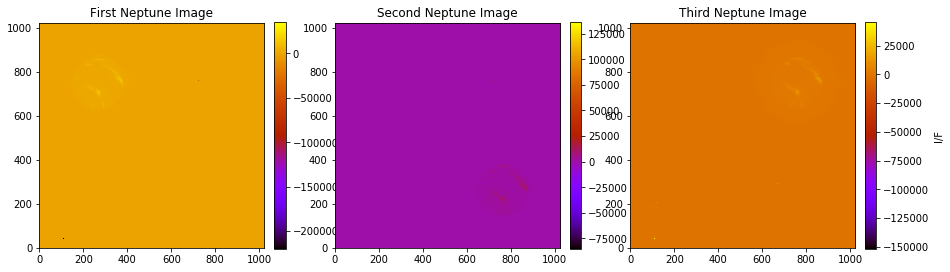

In [103]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(frames_flat[0],origin='lower left',cmap='gnuplot')
plt.title('First Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(frames_flat[1],origin='lower left',cmap='gnuplot')
plt.title('Second Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(frames_flat[2],origin='lower left',cmap='gnuplot')
plt.title('Third Neptune Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Reminder that these images will look much worse than before because we have exaggerated the bad pixels, so don't panic!

# Part 3: Removing Bad Pixels (2.5 pts)
Assuming you made a bad pixel map during the in-class assignment (and that you are in the same directory as your in-class assignment), this should be as simple as opening the 'badpx_map_h.fits' file:

In [104]:
badpx_fits = fits.open(filepath+'badpx_' + filt_name + '.fits',ignore_missing_end=True)
badpx_map = badpx_fits[0].data

<font color=goldenrod>**_Code for you to write_**</font>

Write a function called ```remove_bad_pixels()```, which removes bad pixels from each frame using a nearest neighbor smoothing technique. This will be very similar to the equivalent function from the in-class assignment (with modifications to account for multiple frames):

In [105]:
def remove_bad_pixels(frames,badpx_map):
    for n in range(frames.shape[0]):
        bad_indices = np.where(badpx_map == 0)
        smoothed = medfilt(frames[n],kernel_size = 7)
        frames[n][bad_indices] = smoothed[bad_indices]
        
        for i in range(frames[n].shape[0]):
            for j in range(frames[n].shape[1]):
                if frames[n,i,j] < 0.0:
                    frames[n,i,j] = 0.0
    return frames

Use this function to remove bad pixels from your three Neptune frames.

In [106]:
frames_rm_bp = remove_bad_pixels(frames_flat,badpx_map)

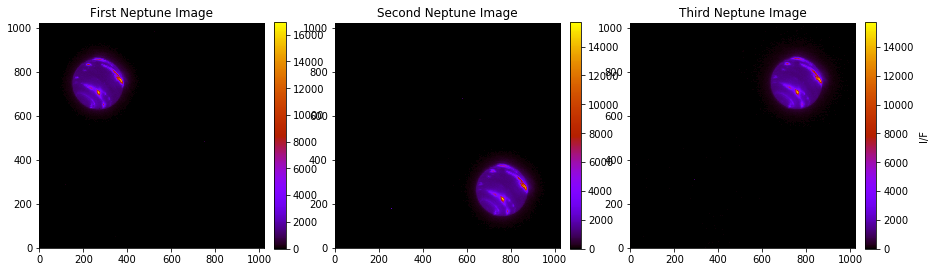

In [107]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(frames_rm_bp[0],origin='lower left',cmap='gnuplot')
plt.title('First Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(frames_rm_bp[1],origin='lower left',cmap='gnuplot')
plt.title('Second Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(frames_rm_bp[2],origin='lower left',cmap='gnuplot')
plt.title('Third Neptune Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

# Part 4. Cosmic ray removal (2.5 pts)

<font color=goldenrod>**_Code for you to write_**</font>

Write a function called ```remove_cosmics()``` which removes cosmic rays using the ```astroscrappy.detect_cosmics()``` function.

In [108]:
def remove_cosmics(frames):
    for i in range(frames.shape[0]):
        crmask, cleanarr = astroscrappy.detect_cosmics(frames[i], cleantype='medmask')
        frames[i] = cleanarr
    return frames

Use this function to remove cosmic rays from your three Neptune frames.

In [109]:
frames_rc = remove_cosmics(frames_rm_bp)

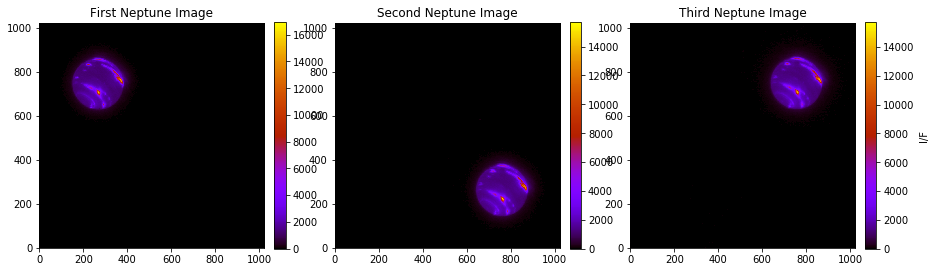

In [110]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(frames_rc[0],origin='lower left',cmap='gnuplot')
plt.title('First Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(frames_rc[1],origin='lower left',cmap='gnuplot')
plt.title('Second Neptune Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(frames_rc[2],origin='lower left',cmap='gnuplot')
plt.title('Third Neptune Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

# Part 5. Stack images using image_registration package (5 pts)
This is an additional step for reducing images taken with the 3 Frame Dither Pattern. We will use two functions from the ```image_registration``` package: ```chi2_shift``` and ```shiftnd```:

In [111]:
image_registration.chi2_shift?

The ```chi2_shift``` function finds cross-correlation between two images using a *Discrete Fourier Transform upsampling* method and returns ```dx``` and ```dy```, which are the offsets between the two images in x and y. This cross correlation method is described in detail in the following video:

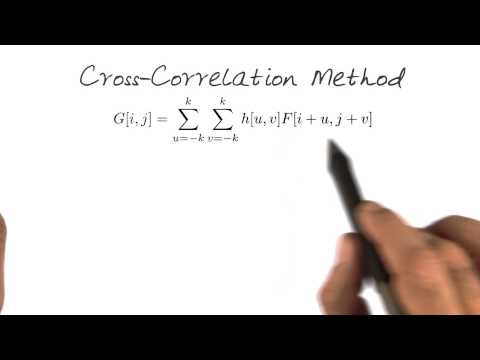

In [112]:
from IPython.display import YouTubeVideo
YouTubeVideo('0IWLr3e7gG4', width=800, height=500)

In [ ]:
image_registration.fft_tools.shiftnd?

The ```shiftnd``` function takes an image and shifts it according to inputs ```dx``` and ```dy```, filling any empty pixels with a value of 0.

<font color=goldenrod>**_Code for you to write_**</font>

Using these two functions, write your own function called ```stack()``` which takes your ```frames_rc``` array as an input and stacks each frame on top of the first frame using cross correlation.

You will need to use the dx, dy output from ```chi2_shift``` in order to shift each frame using ```shiftnd```. Once you have your three frames shifted to have Neptune at the same location, you can stack them by creating an image comprised of the *median* values at each pixel for each shifted frame (similar to the ```make_sky``` function). Then, crop the image to a 512 X 512 square around Neptune:

In [113]:
def stack(frames):
    shifted_data = [frames[0]]
    for frame in frames[1:]:
        [dx,dy,dxerr,dyerr] = image_registration.chi2_shift(frames[0],frame)
        shifted = image_registration.fft_tools.shift2d(frame,-1*dx,-1*dy)
        shifted_data.append(shifted)

    final_stacked = np.median(shifted_data,axis=0)
    final_stacked = final_stacked[512:1024,0:512]
    return final_stacked

Use this function to stack the 3 Neptune frames.

In [114]:
neptune_h = stack(frames_rc)

Plot your image to make sure stacking worked correctly.

Text(0.5, 1.0, 'Neptune H Final Image')

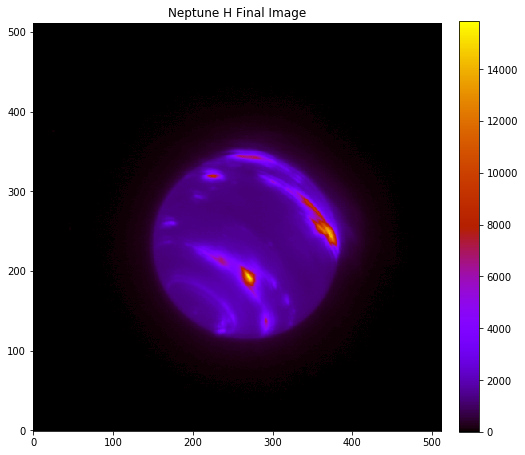

In [115]:
plt.figure(figsize=(8,8))
plt.imshow(neptune_h,origin='lower left',cmap='gnuplot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Neptune H Final Image')

Save your final Neptune H image as a fits file.

In [116]:
fits.writeto(filepath+'/neptune_'+filt_name+'_final.fits',data=neptune_h, overwrite=True)

# Reduce the Neptune Kp Image (2.5 pts)
This should be relatively simple since you have already written the functions for each step.

In [117]:
filt_name = 'kp'
target_name = 'Neptune'

neptune_1f = filepath + target_name + '_' + filt_name + '_1.fits'
neptune_2f = filepath + target_name + '_' + filt_name + '_2.fits'
neptune_3f = filepath + target_name + '_' + filt_name + '_3.fits'
flatf = filepath + 'flat_master_' + filt_name + '.fits'

neptune_1 = fits.open(neptune_1f,ignore_warnings=True,ignore_missing_end=True)
neptune_1_data = neptune_1[0].data
neptune_2 = fits.open(neptune_2f,ignore_warnings=True,ignore_missing_end=True)
neptune_2_data = neptune_2[0].data
neptune_3 = fits.open(neptune_3f,ignore_warnings=True,ignore_missing_end=True)
neptune_3_data = neptune_3[0].data

flat_fits = fits.open(flatf,ignore_warnings=True,ignore_missing_end=True)
flat = flat_fits[0].data

badpx_fits = fits.open(filepath+'badpx_' + filt_name + '.fits',ignore_missing_end=True)
badpx_map = badpx_fits[0].data

frames = np.asarray([neptune_1_data,neptune_2_data,neptune_3_data])

In [118]:
sky_kp = make_sky(frames)
kp_skysub = subtract_sky(frames,sky_kp)
kp_flat = apply_flat(kp_skysub,flat)
kp_rm_bp = remove_bad_pixels(kp_flat,badpx_map)
kp_rc = remove_cosmics(kp_rm_bp)
neptune_kp = stack(kp_rc)

In [119]:
fits.writeto(filepath+'/neptune_'+filt_name+'_final.fits',data=neptune_kp, overwrite=True)

Plot both Neptune images to make sure they look OK.

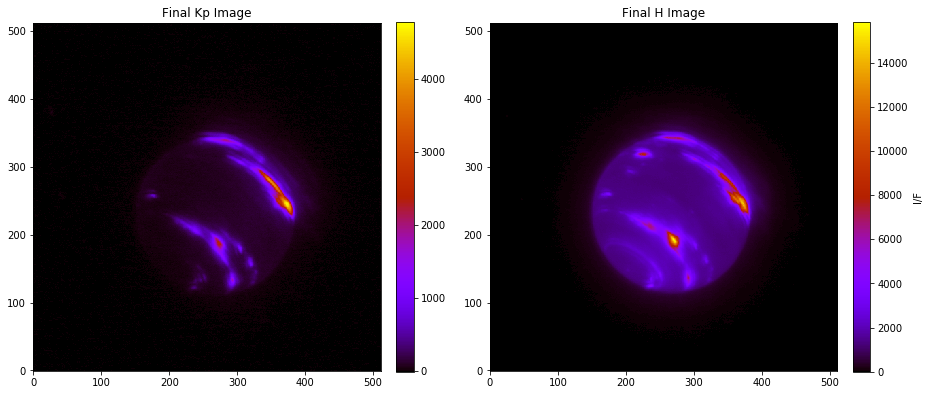

In [120]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(neptune_kp,origin='lower left',cmap='gnuplot')
plt.title('Final Kp Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(neptune_h,origin='lower left',cmap='gnuplot')
plt.title('Final H Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

# Find the pressure at two different clouds on Neptune (5 pts)
Using the cloud pressure equation we used in the in-class assignment (and the graph below), find the pressure of **two** cloud features on Neptune. Pressure is in bars.

<img src="data/neptune_pressure_graph.png" width = 400 align = 'left'>